## RNN Precipitación Cerro Saroche

**PROYECTO:** SISTEMA PARA EL SEGUIMIENTO DE ECOSISTEMAS VENEZOLANOS \
**AUTOR:** Javier Martinez

Directorio de trabajo

In [1]:
import os

print('> Directorio actual: ', os.getcwd())  
os.chdir('../')
print('> Directorio actual: ', os.getcwd()) 

> Directorio actual:  /media/javier/Compartida/doctorado/ssev-analytics/cerro_saroche
> Directorio actual:  /media/javier/Compartida/doctorado/ssev-analytics


In [2]:
from utils.MONGO import CONEXION
from datetime import datetime
import pandas as pd
import numpy as np

from tensorflow import keras

from utils.UTILS import *

# Creando Coenxión con Mongo DB

In [3]:
# Creando la conexión con MongoDB
db = CONEXION.conexion()
db.list_collection_names()

['meteorological', 'estimateSSTNino34', 'SSTNino34']

# Descargando la Información Precipitación

In [4]:
# Parque
park = 'cerro_saroche'

# Realizando consulta
meteorological = db.meteorological.find({"park":park})

# Generando pandas dataframe
data_pandas = pd.DataFrame([file for file in meteorological])
data_pandas['periodo'] = data_pandas.time.apply(lambda x: datetime.fromordinal(x))
data_pandas['mes_year'] =  data_pandas['periodo'].dt.strftime('%B-%Y')
data_pandas.index = pd.to_datetime(data_pandas.periodo)
data_pandas.head()

,_id,id_point,park,time,elevacion_maxima,elevacion_media,elevacion_mediana,latitud,longitud,ndvi_maxima,ndvi_media,ndvi_mediana,precipitacion_mm,time_actualizacion,periodo,mes_year
periodo,,,,,,,,,,,,,,,,
1970-01-01,633988a2eed0e0231b327c97,1,cerro_saroche,719163,921.0,508.541046,491.0,10.31,-69.83,NaN,NaN,NaN,0.913065,738430,1970-01-01,January-1970
1970-01-01,633988a2eed0e0231b327ca7,2,cerro_saroche,719163,1000.0,625.942932,614.0,10.31,-69.73,NaN,NaN,NaN,0.958915,738430,1970-01-01,January-1970
1970-01-01,633988a2eed0e0231b327cc0,3,cerro_saroche,719163,1025.0,731.954834,731.0,10.31,-69.63,NaN,NaN,NaN,1.026073,738430,1970-01-01,January-1970
1970-01-01,633988a2eed0e0231b327ccc,4,cerro_saroche,719163,1103.0,761.129150,737.0,10.31,-69.53,NaN,NaN,NaN,1.095035,738430,1970-01-01,January-1970
1970-01-01,633988a3eed0e0231b327cdc,5,cerro_saroche,719163,1202.0,726.967285,709.0,10.31,-69.43,NaN,NaN,NaN,1.203287,738430,1970-01-01,January-1970


In [5]:
# Registros
print(data_pandas.shape)

(9435, 16)


In [6]:
# Data disponible
print(data_pandas.index.min())
print(data_pandas.index.max())

1970-01-01 00:00:00
2022-05-01 00:00:00


In [7]:
DIR = './cerro_saroche/'

In [8]:
# Cantidad de registros
park_points = data_pandas[[ 'id_point','latitud', 'longitud','precipitacion_mm']]\
                .groupby(['id_point','latitud', 'longitud'],as_index=False)\
                .count()

# Guardando resumen de experimentos
park_points.to_csv(DIR + 'summary/poinst.csv')
park_points

,id_point,latitud,longitud,precipitacion_mm
0,1,10.31,-69.83,629
1,2,10.31,-69.73,629
2,3,10.31,-69.63,629
3,4,10.31,-69.53,629
4,5,10.31,-69.43,629
5,6,10.21,-69.83,629
6,7,10.21,-69.73,629
7,8,10.21,-69.63,629
8,9,10.21,-69.53,629
9,10,10.21,-69.43,629


In [9]:
pd_precipitacion = data_pandas[['id_point', 'latitud', 'longitud',
                                'precipitacion_mm']]
pd_precipitacion.head()

,id_point,latitud,longitud,precipitacion_mm
periodo,,,,
1970-01-01,1,10.31,-69.83,0.913065
1970-01-01,2,10.31,-69.73,0.958915
1970-01-01,3,10.31,-69.63,1.026073
1970-01-01,4,10.31,-69.53,1.095035
1970-01-01,5,10.31,-69.43,1.203287


In [10]:
months = 1

list_data = []

for id in pd_precipitacion.id_point.unique().tolist():

    data = pd_precipitacion.query(f'id_point=={id}').copy()

    y_dif = []
    y_pro = []
    for t in data.index[1:]:

        dif_preci = data[data.index==t]['precipitacion_mm'].values[0] - data[data.index==(t - pd.DateOffset(months=months))]['precipitacion_mm'].values[0] 
        pro_preci = dif_preci/data[data.index==(t - pd.DateOffset(months=months))]['precipitacion_mm'].values[0] 

        y_dif.append(dif_preci)
        y_pro.append(pro_preci)

    data_trans = data[1:].copy()
    data_trans['dif_precipitacion_mm'] = y_dif
    data_trans['pro_precipitacion_mm'] = y_pro

    list_data.append(data_trans)

pd_precipitacion_trans = pd.concat(list_data)

In [11]:
pd_precipitacion_trans.head()

,id_point,latitud,longitud,precipitacion_mm,dif_precipitacion_mm,pro_precipitacion_mm
periodo,,,,,,
1970-02-01,1,10.31,-69.83,0.081278,-0.831787,-0.910983
1970-03-01,1,10.31,-69.83,0.413783,0.332504,4.090928
1970-04-01,1,10.31,-69.83,0.895653,0.481870,1.164550
1970-05-01,1,10.31,-69.83,2.909450,2.013797,2.248411
1970-06-01,1,10.31,-69.83,1.247108,-1.662342,-0.571359


# Cargando data SST

In [12]:
# Realizando consulta
data_sst = db.estimateSSTNino34.find()

# Generando pandas dataframe
pd_sst = pd.DataFrame([file for file in data_sst])[['oni','time']]
pd_sst['periodo'] = pd_sst.time.apply(lambda x: datetime.fromordinal(x))
pd_sst.index = pd.to_datetime(pd_sst.periodo)
pd_sst

pd_sst.head()

,oni,time,periodo
periodo,,,
1950-01-01,-1.470000,711858,1950-01-01
1950-02-01,-1.336667,711889,1950-02-01
1950-03-01,-1.163333,711917,1950-03-01
1950-04-01,-1.180000,711948,1950-04-01
1950-05-01,-1.070000,711978,1950-05-01


In [13]:
oni_max = pd_sst.oni.max()
oni_min = pd_sst.oni.min()

pd_sst['oni'] = pd_sst['oni'].apply(lambda x: (x-oni_min)/(oni_max-oni_min))

<AxesSubplot:xlabel='periodo'>

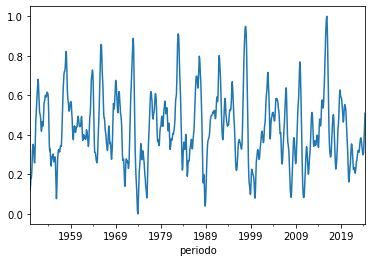

In [14]:
pd_sst.oni.plot()

# Integrando base de datos

In [15]:
# Entrenamiento
pd_model = pd.merge(pd_precipitacion_trans.reset_index(drop=False),pd_sst[['oni']].reset_index(drop=False),
                    on=['periodo'],
                    how='left'
                    )

# Pronostico
pd_sst_pron = pd_sst[['periodo','oni']][pd_sst.periodo > pd_model.periodo.max()].copy()

In [16]:
pd_model.head()

,periodo,id_point,latitud,longitud,precipitacion_mm,dif_precipitacion_mm,pro_precipitacion_mm,oni
0,1970-02-01,1,10.31,-69.83,0.081278,-0.831787,-0.910983,0.506771
1,1970-03-01,1,10.31,-69.83,0.413783,0.332504,4.090928,0.497505
2,1970-04-01,1,10.31,-69.83,0.895653,0.481870,1.164550,0.476123
3,1970-05-01,1,10.31,-69.83,2.909450,2.013797,2.248411,0.444048
4,1970-06-01,1,10.31,-69.83,1.247108,-1.662342,-0.571359,0.369922


# Ajustando modelo RNN

In [17]:
id_point = 1
y_output = 'precip_t'
feature = 'oni'

prediction_order = 12 # rango de prediccion
auto_order = 20*12 # componente autoregresiva

In [18]:
# Data
data_pd = pd_model.query(f'id_point=={id_point}').copy()
data_pd.index = pd.to_datetime(data_pd.periodo)

from sklearn.preprocessing import MinMaxScaler
pre_scaler = MinMaxScaler()

pre_scaler.fit(data_pd[['dif_precipitacion_mm']])
data_pd['precip_t']  = pre_scaler.transform(data_pd[['dif_precipitacion_mm']])

data_pd = data_pd[[y_output,feature]].sort_index().copy()
data_pd.head()

,precip_t,oni
periodo,,
1970-02-01,0.440730,0.506771
1970-03-01,0.523449,0.497505
1970-04-01,0.534061,0.476123
1970-05-01,0.642900,0.444048
1970-06-01,0.381721,0.369922


<AxesSubplot:xlabel='periodo'>

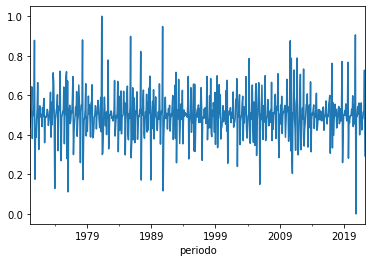

In [19]:
data_pd.precip_t.plot()

Redefiniendo serie temporal

In [20]:
x_data = []
y_data = []

for t in range(auto_order+1, data_pd.shape[0]+1):
    x_data.append( np.array(data_pd[(t-auto_order-1):(t-1)]) )
    y_data.append( np.array( data_pd[(t-auto_order-1):t][[y_output]] )[-1] )

In [21]:
x_data = np.array(x_data)
y_data = np.array(y_data).reshape(x_data.shape[0],1,1)

Entrenamiento y validación

In [22]:
x_train = x_data[:-prediction_order]
x_vasl = x_data[-prediction_order:]

y_train = y_data[:-prediction_order]
y_vasl = y_data[-prediction_order:]

print(x_train.shape)
print(x_vasl.shape)

print(y_train.shape)
print(y_vasl.shape)

(376, 240, 2)
(12, 240, 2)
(376, 1, 1)
(12, 1, 1)


Modelos RNN

In [23]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [24]:
# Metrícas
mae = keras.metrics.MeanAbsoluteError()
rmse = keras.metrics.RootMeanSquaredError()

In [25]:
model = keras.models.Sequential()

rate = 0.2
model.add(keras.layers.LSTM(auto_order, return_sequences=False ))
# model.add(keras.layers.Dropout(rate))

# model.add(keras.layers.LSTM(auto_order, return_sequences=False ))
# model.add(keras.layers.Dropout(rate-0.1))

model.add(keras.layers.Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=[mae,rmse]) 

In [26]:
callback = keras.callbacks.EarlyStopping(
                                            monitor="loss",
                                            min_delta=0,
                                            patience=10,
                                            verbose=0,
                                            mode="min",
                                            baseline=None,
                                            restore_best_weights=False,
                                        )

Entrenamiento

In [27]:
epochs=500

history = model.fit(x=x_train,
                    y=y_train,
                    epochs=epochs,
                    batch_size=1,
                    verbose=0,
                    workers=2,
                    callbacks=[callback])

In [28]:
print(f'Total epocas:{len(history.epoch)}')

Total epocas:80


Evaluación

In [29]:
# make predictions
trainPredict = model.predict(x_train, verbose=0).reshape(-1)
testPredict = model.predict(x_vasl, verbose=0).reshape(-1)

In [30]:
trainPredict.shape

(376,)

In [31]:
# Data de test
trainind_pd = pd.DataFrame(trainPredict,
                            index = data_pd.index[:-prediction_order][-len(trainPredict):],
                            columns=['prediction']
                            )

trainind_pd[y_output] = y_train.reshape(-1)
trainind_pd['type'] = 'training'
# trainind_pd['precipitacion_mm'] = trainind_pd[y_output].apply(lambda x: transformacion.inversa(x) if np.isnan(x)==False else np.nan )
# trainind_pd['prediction_precipitacion_mm'] = trainind_pd['prediction'].apply(lambda x: transformacion.inversa(x) if np.isnan(x)==False else np.nan )

trainind_pd.head()

,prediction,precip_t,type
periodo,,,
1990-02-01,0.434017,0.517333,training
1990-03-01,0.477031,0.479003,training
1990-04-01,0.545849,0.657875,training
1990-05-01,0.409142,0.517005,training
1990-06-01,0.402017,0.353179,training


<AxesSubplot:xlabel='periodo'>

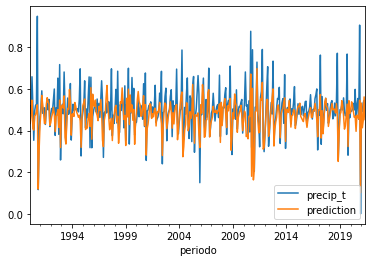

In [32]:
trainind_pd[['precip_t','prediction']].plot()

In [33]:
trainig_metrics = metrics(observado=trainind_pd.precip_t,prediccion=trainind_pd.prediction)
trainig_metrics

{'mape': 121852134491516.84,
 'mae': 0.05465669647178779,
 'mse': 0.07870100451762876,
 'rmse': 0.006193848112083822,
 'r2': 0.4787062197843349}

In [35]:
# Data de Validacion
validation_pd = pd.DataFrame(testPredict,
                            index = data_pd.index[-prediction_order:],
                            columns=['prediction']
                            )

validation_pd[y_output] = y_vasl.reshape(-1)
validation_pd['type'] = 'validation'

# validation_pd['precipitacion_mm'] = validation_pd[y_output].apply(lambda x: transformacion.inversa(x) if np.isnan(x)==False else np.nan )
# validation_pd['prediction_precipitacion_mm'] = validation_pd['prediction'].apply(lambda x: transformacion.inversa(x) if np.isnan(x)==False else np.nan )
validation_pd.head()

,prediction,precip_t,type
periodo,,,
2021-06-01,0.408667,0.560988,validation
2021-07-01,0.409080,0.399982,validation
2021-08-01,0.546942,0.534115,validation
2021-09-01,0.530266,0.470040,validation
2021-10-01,0.629418,0.561614,validation


In [36]:
validation_metrics = metrics(observado=validation_pd.precip_t,prediccion=validation_pd.prediction)
validation_metrics

{'mape': 12.945009733536983,
 'mae': 0.07098632582048857,
 'mse': 0.09885241003127067,
 'rmse': 0.00977179896899046,
 'r2': 0.026848713906082122}

<AxesSubplot:xlabel='periodo'>

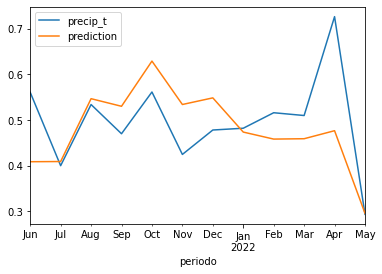

In [37]:
validation_pd[['precip_t','prediction']].plot()

In [38]:
def precipitacion_data_rnn(data_pd,auto_order,y_output):
    """
    Funcion para darle estructura a los datos para modelo rnn
    """

    x_data = []
    y_data = []

    for t in range(auto_order+1, data_pd.shape[0]+1):
        x_data.append( np.array(data_pd[(t-auto_order-1):(t-1)]) )
        y_data.append( np.array( data_pd[(t-auto_order-1):t][[y_output]] )[-1] )

    x_data = np.array(x_data)
    y_data = np.array(y_data).reshape(x_data.shape[0],1,1)

    return x_data, y_data

In [39]:
def one_step_predict(data_for_test,pd_sst_pron,auto_order,y_output,feature):
    """
    Funcion para el pronostico a un paso de la precipitacion
    """

    for t in pd_sst_pron.index:

        x_entrada, y_salida = precipitacion_data_rnn(data_pd=data_for_test[data_for_test.index < t],
                                                    auto_order=auto_order,
                                                    y_output=y_output)

        predict = model.predict(x_entrada, verbose=0).reshape(-1)

        data_forecast = pd.DataFrame({y_output:predict[-1],
                                feature:pd_sst_pron[pd_sst_pron.index == t][feature][0]},
                                index = [t])
                                
        data_for_test = pd.concat([data_for_test, data_forecast]).copy()

    return data_for_test

In [40]:
pd_test = one_step_predict(data_for_test=data_pd[:(data_pd.shape[0] - auto_order)],
                pd_sst_pron=data_pd[-auto_order:],
                auto_order=auto_order,
                y_output=y_output,
                feature=feature)

pd_test = pd_test[-auto_order:].rename(columns={'precip_t':'prediction'})
pd_test['type'] = 'test'
pd_test[y_output] = data_pd[-auto_order:][y_output]


# pd_test['precipitacion_mm'] = pd_test[y_output].apply(lambda x: transformacion.inversa(x) if np.isnan(x)==False else np.nan )
# pd_test['prediction_precipitacion_mm'] = pd_test['prediction'].apply(lambda x: transformacion.inversa(x) if np.isnan(x)==False else np.nan )
pd_test.head()

,prediction,oni,type,precip_t
2002-06-01,0.433376,0.573770,test,0.240229
2002-07-01,0.280029,0.603706,test,0.485760
2002-08-01,0.330025,0.619387,test,0.492398
2002-09-01,0.511397,0.650748,test,0.563266
2002-10-01,0.655357,0.693514,test,0.603221


<AxesSubplot:>

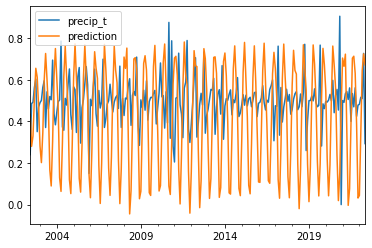

In [42]:
pd_test[['precip_t','prediction']].plot()

In [41]:
test_metrics = metrics(observado=pd_test.precip_t,prediccion=pd_test.prediction)
test_metrics

{'mape': 870908190610823.1,
 'mae': 0.24049485052412944,
 'mse': 0.2923011987286623,
 'rmse': 0.08543999077821292,
 'r2': -5.676441069363879}

In [ ]:
pd_prediction = one_step_predict(data_for_test=data_pd,
                                pd_sst_pron=pd_sst_pron,
                                auto_order=auto_order,
                                y_output=y_output,
                                feature=feature)

In [ ]:
pd_prediction = pd_prediction.rename(columns={'precip_t':'prediction'})
pd_prediction['type'] = 'prediction'

pd_prediction[y_output] = np.nan

pd_prediction['precipitacion_mm'] =  np.nan
pd_prediction['prediction_precipitacion_mm'] = pd_prediction['prediction'].apply(lambda x: transformacion.inversa(x) if np.isnan(x)==False else np.nan )

pd_prediction.head()

,prediction,oni,type,precip_t,precipitacion_mm,prediction_precipitacion_mm
1970-01-01,0.609060,0.543835,prediction,NaN,NaN,0.913065
1970-02-01,0.167493,0.506771,prediction,NaN,NaN,0.081278
1970-03-01,0.464581,0.497505,prediction,NaN,NaN,0.413783
1970-04-01,0.605545,0.476123,prediction,NaN,NaN,0.895653
1970-05-01,0.820615,0.444048,prediction,NaN,NaN,2.909450


In [ ]:
# Resultados del modelo
dict_metrics = {'epocas':[len(history.epoch)],
                'auto_order':[auto_order],
                'id_point':[id_point],
                'training_mse':[history.history["loss"][-1]],
                'training_rmse':[history.history["root_mean_squared_error"][-1]],
                'training_mae':[history.history["mean_absolute_error"][-1]],
                'trainig_mape':[trainig_metrics['mape']],
                'trainig_r':[trainig_metrics['r2']],
                'validation_mse':[validation_metrics["mse"]],
                'validation_rmse':[validation_metrics["rmse"]],
                'validation_mae':[validation_metrics["mae"]],
                'validation_mape':[validation_metrics['mape']],
                'validation_r':[validation_metrics['r2']],
                'test_mse':[test_metrics["mse"]],
                'test_rmse':[test_metrics["rmse"]],
                'test_mae':[test_metrics["mae"]],
                'test_mape':[test_metrics['mape']],
                'test_r':[test_metrics['r2']]
                }

experimento_pd = pd.DataFrame.from_dict(dict_metrics)
experimento_pd

,epocas,auto_order,id_point,training_mse,training_rmse,training_mae,trainig_mape,trainig_r,validation_mse,validation_rmse,validation_mae,validation_mape,validation_r,test_mse,test_rmse,test_mae,test_mape,test_r
0,196,12,1,0.015218,0.12336,0.097935,61.704877,0.471853,1.38366,1.914514,0.972171,168.291152,-1.049535,1.353378,1.831632,1.047542,454.304314,-0.960808


In [ ]:
columns = [ 'precip_t',
            'prediction',
            #'oni',
            'type',
            'precipitacion_mm',
            'prediction_precipitacion_mm']

In [ ]:
# Uniendo informacion
pd_summary = pd.concat([trainind_pd[columns], 
                        pd_test[columns], 
                        pd_prediction[columns]
                        ])
pd_summary['periodo'] = pd.to_datetime(pd_summary.index.values)
pd_summary = pd_summary[ ['periodo']+ columns ]
pd_summary

,periodo,precip_t,prediction,type,precipitacion_mm,prediction_precipitacion_mm
1971-01-01,1971-01-01,0.488734,0.469698,training,0.472320,0.425546
1971-02-01,1971-02-01,0.283769,0.417885,training,0.153676,0.320390
1971-03-01,1971-03-01,0.515458,0.506914,training,0.546783,0.521779
1971-04-01,1971-04-01,0.817589,0.717392,training,2.861612,1.652848
1971-05-01,1971-05-01,0.825787,0.759201,training,2.993050,2.078264
...,...,...,...,...,...,...
2024-02-01,2024-02-01,NaN,0.502425,prediction,NaN,0.509105
2024-03-01,2024-03-01,NaN,0.573754,prediction,NaN,0.752498
2024-04-01,2024-04-01,NaN,0.630557,prediction,NaN,1.027175
2024-05-01,2024-05-01,NaN,0.671114,prediction,NaN,1.282727
